# Exploración de avisos

## Conexión a DB

In [16]:
from pymongo import MongoClient
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
load_dotenv()
db_uri = os.getenv('DBURI')

In [3]:
client = MongoClient(db_uri)
db = client['portalinmobiliario']
collection = db['propiedades']

In [4]:
propiedades = list(collection.find({}))

## Exploración

In [5]:
df = pd.DataFrame(propiedades)

In [6]:
df.dtypes

_id                            object
uuid                           object
fecha_obtencion        datetime64[ns]
url                            object
tipo_operacion                 object
tipo_propiedad                 object
modalidad                      object
region                         object
comuna                         object
barrio                         object
titulo                         object
simbolo_moneda                 object
precio                         object
ubicacion                      object
latitud                        object
longitud                       object
caracteristicas                object
descripcion                    object
info_zona                      object
ref_precio                     object
corredora                      object
fecha_actualizacion    datetime64[ns]
publicacion_vigente             int64
dtype: object

In [7]:
df.groupby('comuna')['uuid'].count()

comuna
la-florida      4854
macul           2844
nunoa          14995
providencia    11614
Name: uuid, dtype: int64

In [8]:
df.groupby('publicacion_vigente')['uuid'].count()

publicacion_vigente
0    18590
1    15717
Name: uuid, dtype: int64

In [9]:
df.groupby(['publicacion_vigente', 'tipo_propiedad', 'comuna'])['uuid'].count()

publicacion_vigente  tipo_propiedad  comuna     
0                    casa            la-florida     1012
                                     macul           320
                                     nunoa          1332
                                     providencia    1109
                     departamento    la-florida      952
                                     macul           850
                                     nunoa          7302
                                     providencia    5713
1                    casa            la-florida     1547
                                     macul           406
                                     nunoa           924
                                     providencia     853
                     departamento    la-florida     1343
                                     macul          1268
                                     nunoa          5437
                                     providencia    3939
Name: uuid, dtype: int64

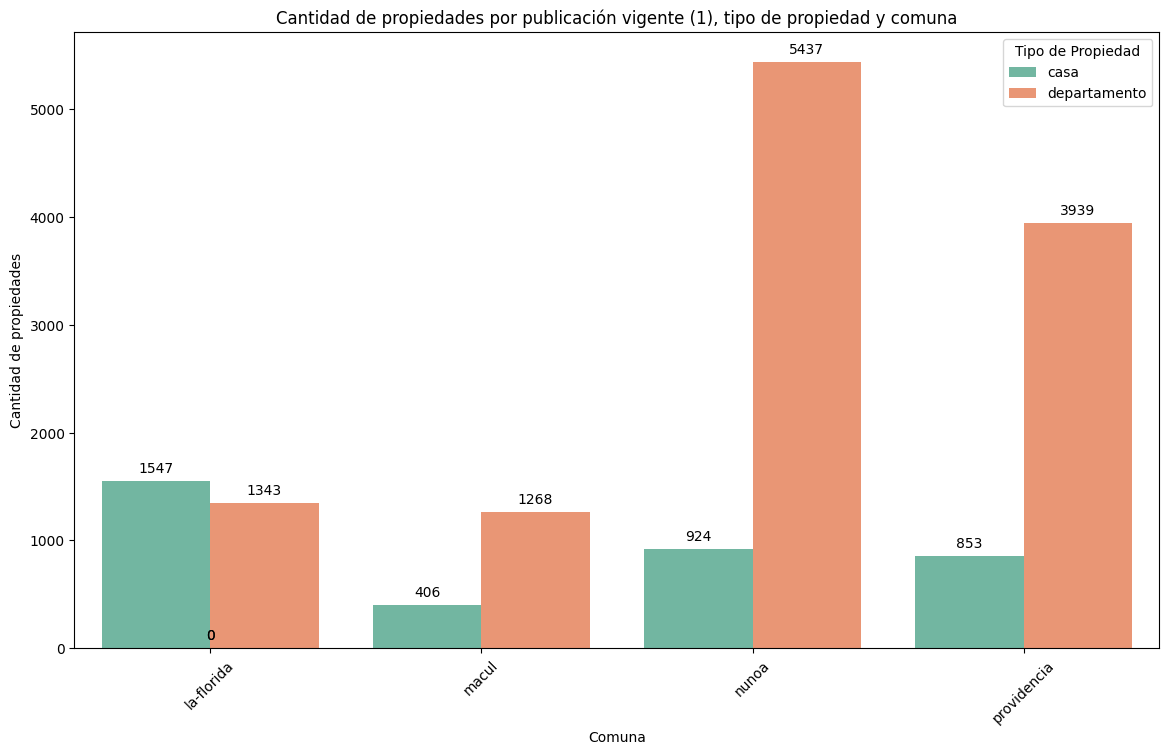

In [31]:
df_grouped = df.groupby(['publicacion_vigente', 'tipo_propiedad', 'comuna'])['uuid'].count().reset_index()
df_grouped.columns = ['publicacion_vigente', 'tipo_propiedad', 'comuna', 'count']

df_filtered = df_grouped.query('publicacion_vigente == 1')

# Crear el gráfico
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='comuna', y='count', hue='tipo_propiedad', data=df_filtered, palette='Set2', errorbar=None)

# Añadir valores encima de las barras
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.title('Cantidad de propiedades por publicación vigente (1), tipo de propiedad y comuna')
plt.xlabel('Comuna')
plt.ylabel('Cantidad de propiedades')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Propiedad')

plt.show()

## Conversión de moneda

In [34]:
df['simbolo_moneda'].unique()

array(['UF', '$', 'U$S'], dtype=object)

In [38]:
df['precio'] = pd.to_numeric(df['precio'], errors='coerce')

In [39]:
tasa_conversion_clp_a_uf = 37445
tasa_conversion_usd_a_uf = 917 / 30000 

def convertir_a_uf(row):
    if row['simbolo_moneda'] == '$':
        return row['precio'] / tasa_conversion_clp_a_uf
    elif row['simbolo_moneda'] == 'U$S':
        return row['precio'] * tasa_conversion_usd_a_uf
    else:  # Asumimos que si no es CLP ni USD, ya está en UF
        return row['precio']

In [40]:
df['precio_en_uf'] = df.apply(convertir_a_uf, axis=1)

In [44]:
print(df[['precio_en_uf', 'precio', 'url']].head())

   precio_en_uf  precio                                                url
0         3.200   3.200  https://www.portalinmobiliario.com/MLC-1474053...
1         7.000   7.000  https://www.portalinmobiliario.com/MLC-2353364...
2         4.200   4.200  https://www.portalinmobiliario.com/MLC-2364798...
3           NaN     NaN  https://www.portalinmobiliario.com/MLC-2355043...
4         6.233   6.233  https://www.portalinmobiliario.com/MLC-2353455...


In [48]:
pd.set_option('display.max_colwidth', None)

filtro = df[df['precio'].isna() & (df['publicacion_vigente'] == 1)]
print(filtro[['precio_en_uf', 'precio', 'url']].head())

     precio_en_uf  precio  \
7             NaN     NaN   
35            NaN     NaN   
123           NaN     NaN   
136           NaN     NaN   
167           NaN     NaN   

                                                                                                              url  
7                      https://www.portalinmobiliario.com/MLC-2353399452-departamento-en-venta-en-providencia-_JM  
35                                   https://www.portalinmobiliario.com/MLC-2331566034-dpto-bilbao-bustamante-_JM  
123          https://www.portalinmobiliario.com/MLC-2209856958-venta-depto-antiguo-passy-bustamante-vmackenna-_JM  
136  https://www.portalinmobiliario.com/MLC-2335752290-comodo-departamento-de-dos-habitaciones-en-providencia-_JM  
167          https://www.portalinmobiliario.com/MLC-2237257278-departamento-en-venta-de-2-dorm-en-providencia-_JM  


In [49]:
nan_precio = df['precio'].isna().sum()
print(f"Número de NaN en la columna 'precio': {nan_precio}")

Número de NaN en la columna 'precio': 4034


In [53]:
# Ordenar el DataFrame por precio en orden descendente
df_precios_ordenado = df_precios.sort_values(by='precio', ascending=True)

# Opcional: Si quieres visualizar solo las URLs de las propiedades más caras
print(df_precios_ordenado[['precio', 'url']].head())

       precio  \
4850     0.00   
4421     1.00   
32407    1.15   
13663    1.15   
18522    1.16   

                                                                                                                    url  
4850         https://www.portalinmobiliario.com/MLC-1473005825-venta-unica-terreno-1034m2-en-corazon-de-providencia-_JM  
4421   https://www.portalinmobiliario.com/MLC-2337517720-se-vende-derecho-a-llave-de-jardin-infantil-en-providencia-_JM  
32407          https://www.portalinmobiliario.com/MLC-2460955924-venta-promesa-departamento-nuevo-entrega-inmediata-_JM  
13663          https://www.portalinmobiliario.com/MLC-1464751453-venta-promesa-departamento-nuevo-entrega-inmediata-_JM  
18522      https://www.portalinmobiliario.com/MLC-2385958604-se-vende-promesa-de-compraventa-en-macul-a-precio-2021-_JM  
